<a href="https://colab.research.google.com/github/adammia/AndroidWearQRGenerator/blob/master/Sportolok_AM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Üzleti Elemzések módszertana (UZNA0BA06) - Beadandó feladat
> ### Sportolók teljesítményprofiljának klaszterezése
      sport_id - sportolók egyedi azonosító száma
      versenyek_szama - hány versenyen vett részt a sportoló  
      pontszám - a sportoló által elért összesített pontszám  
      teljesitmeny_index - a sportoló teljesítményének számított indexe  
      napok_ota - hány napja volt a sportoló utolsó versenye

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import os
from seaborn import scatterplot as scatter
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
import warnings
warnings.filterwarnings(action="ignore")

In [ ]:
# Adatok betöltése
df = pd.read_csv('C:\\UEM\\Sportolok_teljesitmeny.csv', encoding='iso-8859-2')
print(df.head())

   sport_id  versenyek_szama  pontszam  teljesitmeny_index  napok_ota
0         1               28   3516175               11.04       1197
1         2                1    115739                9.65       1882
2         3               49    729852                8.50          5
3         4                1    106570                8.12        938
4         5                1    143767               13.31       1363


 ### Adatok átvizsgálása, adatelőkészítés

In [ ]:
 df.shape

(6506, 5)

In [ ]:
 df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6506 entries, 0 to 6505
Data columns (total 5 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   sport_id            6506 non-null   int64  
 1   versenyek_szama     6506 non-null   int64  
 2   pontszam            6506 non-null   int64  
 3   teljesitmeny_index  6506 non-null   float64
 4   napok_ota           6506 non-null   int64  
dtypes: float64(1), int64(4)
memory usage: 254.3 KB


In [ ]:
 # Duplikációk kiszűrése, eltávolítása
print(f"Kezdeti sorok száma: {df.shape[0]}")
print("Duplikált sorok száma:", df.duplicated().sum())
df.drop_duplicates(inplace=True)
df.dropna(inplace=True)
print(f"Végleges sorok száma: {df.shape[0]}")

Kezdeti sorok száma: 6506
Duplikált sorok száma: 2
Végleges sorok száma: 6504


In [ ]:
 print("A hiányzó értékek vizsgálata:")# Nincs hiányzó érték
df.isna().sum()

A hiányzó értékek vizsgálata:


sport_id              0
versenyek_szama       0
pontszam              0
teljesitmeny_index    0
napok_ota             0
dtype: int64

In [ ]:
# Azonosítók átalakítása stringgé
df['sport_id'] = df['sport_id'].astype(str)

In [ ]:
# Leíró statisztikai lekérdezés
df.describe()

,versenyek_szama,pontszam,teljesitmeny_index,napok_ota
count,6504.000000,6.504000e+03,6.504000e+03,6504.000000
mean,8.578875,3.776365e+05,4.551190e+02,413.490314
std,18.982399,9.134196e+05,1.689225e+04,463.880531
min,1.000000,7.300000e+01,2.380000e+00,0.000000
25%,1.000000,1.790100e+04,9.910000e+00,42.000000
50%,3.000000,9.406650e+04,1.647000e+01,232.000000
75%,8.000000,3.331938e+05,2.567250e+01,624.000000
max,324.000000,2.730395e+07,1.255648e+06,1956.000000


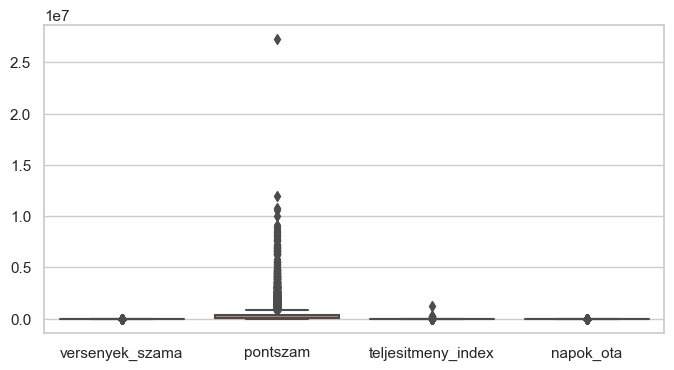

In [ ]:
#Adatok ábrázolása boxploton, megfigyelhető outlier a pontszám oszlopnál
sns.set(rc={'figure.figsize':(8,4)}, font_scale=1, style='whitegrid')
sns.boxplot(data=df)
plt.show()

### Outlier adatok kiszűrése

In [ ]:
# z-score módszer
upper = df.pontszam.mean() + 3*df.pontszam.std()
lower = df.pontszam.mean() -3*df.pontszam.std()
print(upper)
print(lower)

3117895.3028964074
-2362622.286906248


In [ ]:
df= df[(df.pontszam<upper) & (df.pontszam>lower)]

In [ ]:
df.shape

(6385, 5)

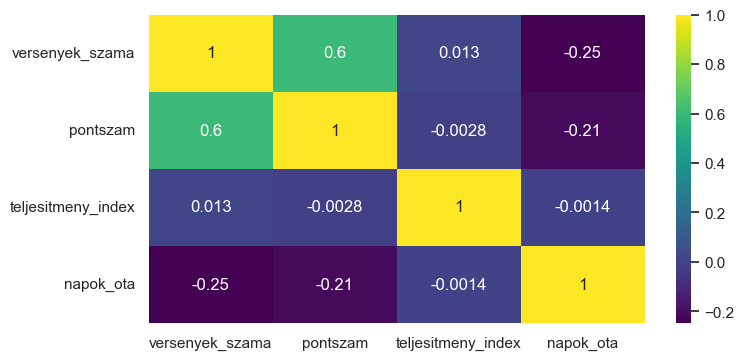

In [ ]:
# Korreláció vizsgálat
dfc = df.corr()
plt.figure(figsize=(8,4))
heat_map = sns.heatmap(dfc , annot=True , cmap='viridis')
plt.show()

In [ ]:
# Leíró statisztikai lekérdezés (előkészítés után)
df.describe()

,versenyek_szama,pontszam,teljesitmeny_index,napok_ota
count,6385.000000,6.385000e+03,6.385000e+03,6385.000000
mean,7.290995,2.853613e+05,4.633319e+02,419.985748
std,13.923818,4.880213e+05,1.704885e+04,465.177117
min,1.000000,7.300000e+01,2.380000e+00,0.000000
25%,1.000000,1.726500e+04,9.980000e+00,45.000000
50%,3.000000,8.936100e+04,1.673000e+01,242.000000
75%,7.000000,3.049700e+05,2.590000e+01,641.000000
max,264.000000,3.115587e+06,1.255648e+06,1956.000000


In [ ]:
X = df.values # Áttöltés numpy tömbbe

In [ ]:
# Sztenderdizálás
from sklearn.preprocessing import StandardScaler
sc_X = StandardScaler()
X = sc_X.fit_transform(X)

### Optimális klaszterszám meghatározása

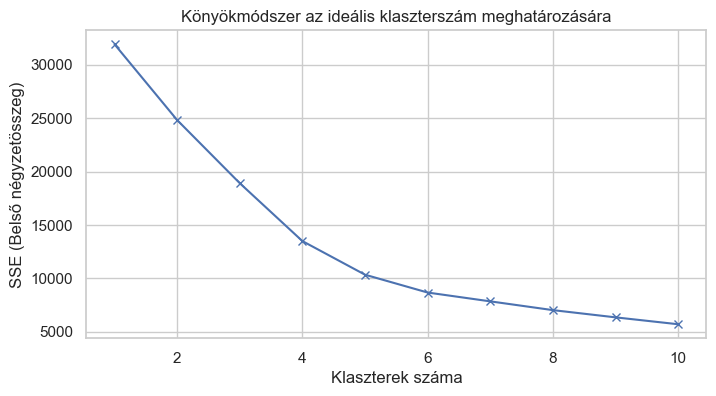

In [ ]:
# Könyökmódszer az ideális klaszterszám meghatározására
from sklearn.cluster import KMeans
wcss = []
for i in range(1, 11):
    kmeans = KMeans(n_clusters=i, max_iter=300, n_init=100, random_state=1)
    kmeans.fit(X)
    wcss.append(kmeans.inertia_)

# Könyökdiagram megjelenítése
plt.figure(figsize=(8,4))
plt.plot(range(1, 11), wcss, marker='x', linestyle='-', color='b')
plt.title('Könyökmódszer az ideális klaszterszám meghatározására', fontsize=12)
plt.xlabel('Klaszterek száma', fontsize=12)
plt.ylabel('SSE (Belső négyzetösszeg)', fontsize=12)
plt.grid(True)
plt.show()

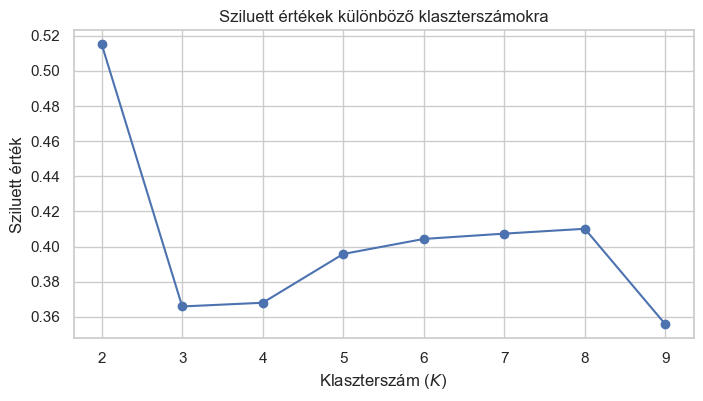

In [ ]:
# Sziluett értékek számítása különböző klaszterszámokra
silhouettes = [silhouette_score(X, KMeans(n_clusters=k, random_state=1).fit(X).labels_) for k in range(2, 10)]
plt.figure(figsize=(8, 4))
plt.plot(range(2, 10), silhouettes, 'bo-')
plt.title("Sziluett értékek különböző klaszterszámokra")
plt.xlabel('Klaszterszám ($K$)')
plt.ylabel('Sziluett érték')
plt.grid(True)
plt.show()

### K-Means 3 klaszterrel

In [ ]:
# Klaszterezés
kmeans =KMeans(n_clusters = 3, max_iter=300, n_init=10, random_state=1)
y_kmeans=kmeans.fit_predict(X)

In [ ]:
df['Klaszter']=y_kmeans # A klaszter oszlop létrehozása

In [ ]:
df['Klaszter'].value_counts()

0    3048
1    2789
2     548
Name: Klaszter, dtype: int64

In [ ]:
szam=df['Klaszter'].value_counts()

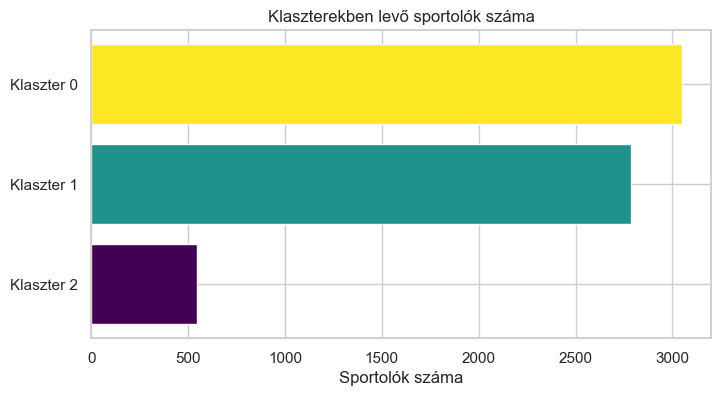

In [ ]:
# Klaszterek sportolói számának megjelenítése
plt.figure(figsize=(8, 4))
szam_sorted = szam.sort_values(ascending=True)
colors = plt.cm.viridis(np.linspace(0, 1, len(szam_sorted)))

plt.barh(szam_sorted.index, szam_sorted, color=colors)
plt.xlabel('Sportolók száma')
plt.title('Klaszterekben levő sportolók száma')
plt.yticks(ticks=szam_sorted.index, labels=['Klaszter ' + str(idx) for idx in szam_sorted.index])
plt.gca().invert_yaxis()
plt.show()

### Klaszter kimutatások készítése

In [ ]:
# Az egyes klaszterek szétválasztása
klaszter0 = df[df.Klaszter == 0]
klaszter1 = df[df.Klaszter == 1]
klaszter2 = df[df.Klaszter == 2]

In [ ]:
# Klaszterenkénti oszlopátlagok kiszámítása
data=[klaszter0.mean().values,klaszter1.mean().values,klaszter2.mean().values]
indexes=['K0_avg','K1_avg','K2_avg']
klaszter_avg = pd.DataFrame(data, columns=df.columns, index=indexes)
klaszter_avg

,sport_id,versenyek_szama,pontszam,teljesitmeny_index,napok_ota,Klaszter
K0_avg,inf,4.823491,1.616510e+05,420.800692,199.488189,0.0
K1_avg,inf,4.088562,1.739292e+05,524.866185,724.354249,1.0
K2_avg,inf,37.313869,1.540568e+06,386.718741,97.344891,2.0


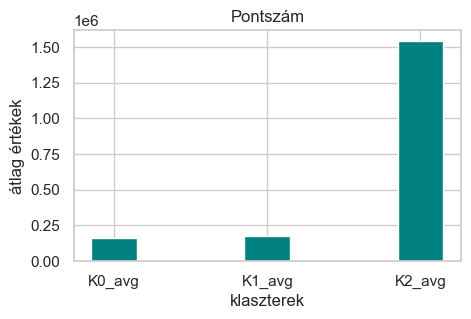

In [ ]:
# Klaszterenkénti átlagok ábrázolása
plt.rcParams["figure.figsize"] = (5,3)
plt.bar(indexes, klaszter_avg.pontszam, width=0.3, color='teal')
plt.xlabel('klaszterek')
plt.ylabel('átlag értékek')
plt.title('Pontszám')
plt.show()

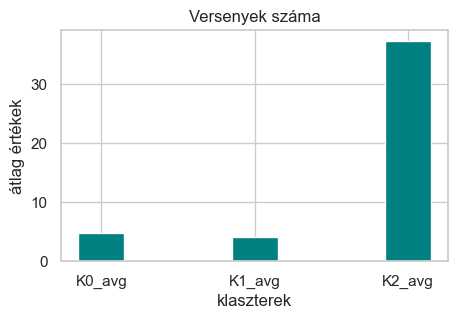

In [ ]:
plt.rcParams["figure.figsize"] = (5,3)
plt.bar(indexes, klaszter_avg.versenyek_szama, width=0.3, color='teal')
plt.xlabel('klaszterek')
plt.ylabel('átlag értékek')
plt.title('Versenyek száma')
plt.show()

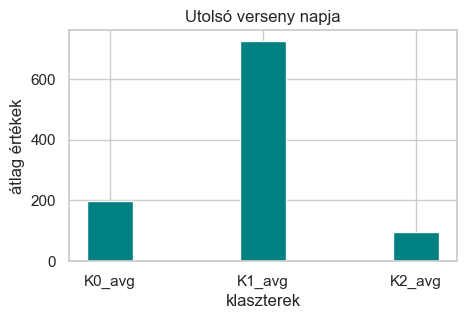

In [ ]:
plt.rcParams["figure.figsize"] = (5,3)
plt.bar(indexes, klaszter_avg.napok_ota, width=0.3, color='teal')
plt.xlabel('klaszterek')
plt.ylabel('átlag értékek')
plt.title('Utolsó verseny napja')
plt.show()

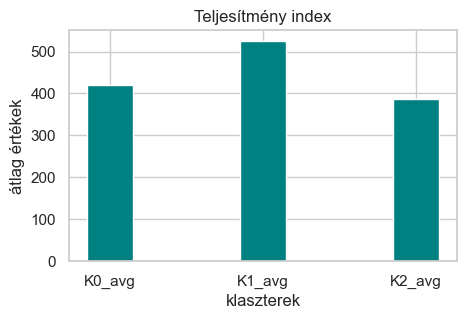

In [ ]:
plt.rcParams["figure.figsize"] = (5,3)
plt.bar(indexes, klaszter_avg.teljesitmeny_index, width=0.3, color='teal')
plt.xlabel('klaszterek')
plt.ylabel('átlag értékek')
plt.title('Teljesítmény index')
plt.show()

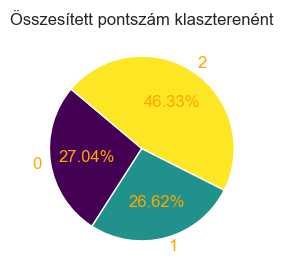

In [ ]:
# Összesített pontszám klaszterenént
fs = 12  # betűméret
colors = plt.get_cmap('viridis')  # színpaletta

# Adatok csoportosítása és összegzése
grouped_data = df.groupby('Klaszter')['pontszam'].sum()

# Kör diagram megjelenítése
fig, ax = plt.subplots(figsize=(5, 3))  # Az ábra méretének és pozíciójának beállítása
ax.pie(grouped_data, labels=grouped_data.index, autopct='%.2f%%', startangle=140, colors=colors(np.linspace(0, 1, len(grouped_data))), textprops={'fontsize': fs, 'color': 'orange'})
ax.set_title('Összesített pontszám klaszterenént', fontsize=fs)
plt.show()

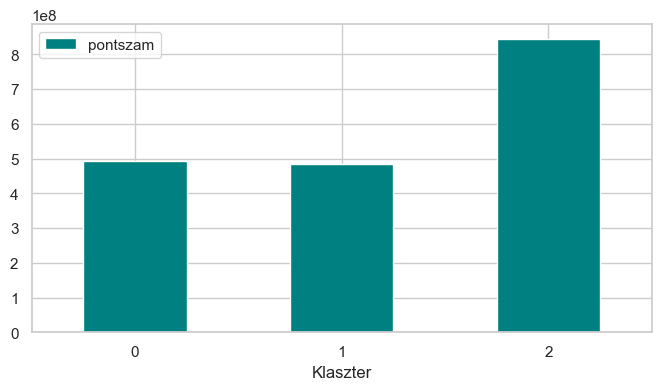

In [ ]:
plt.rcParams["figure.figsize"] = (8,4)
df.groupby(['Klaszter'])[['pontszam']].sum().plot(kind='bar', color='teal')
plt.xticks(rotation=0);

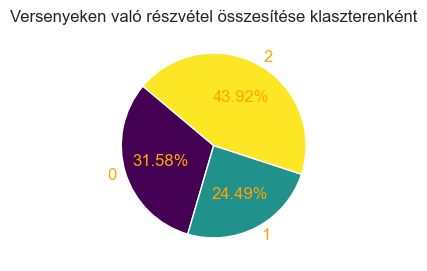

In [ ]:
# Versenyeken való részvétel összesítése klaszterenként
fs = 12
colors = plt.get_cmap('viridis')

# Adatok csoportosítása és összegzése
grouped_data = df.groupby('Klaszter')['versenyek_szama'].sum()

# Kördiagram megjelenítése
fig, ax = plt.subplots(figsize=(5, 3))
ax.pie(grouped_data, labels=grouped_data.index, autopct='%.2f%%', startangle=140, colors=colors(np.linspace(0, 1, len(grouped_data))), textprops={'fontsize': fs, 'color': 'orange'})
ax.set_title('Versenyeken való részvétel összesítése klaszterenként', fontsize=fs)
plt.show()

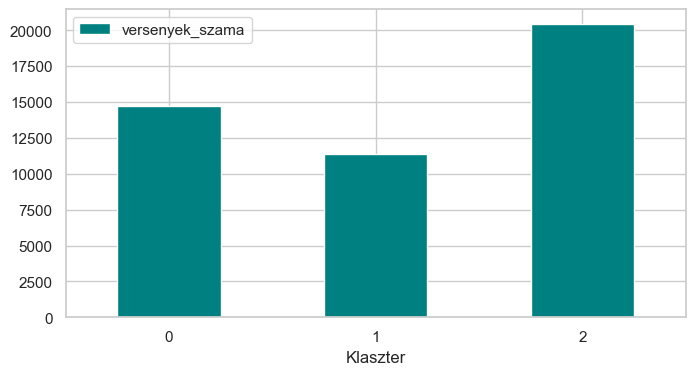

In [ ]:
plt.rcParams["figure.figsize"] = (8,4)
df.groupby(['Klaszter'])[['versenyek_szama']].sum().plot(kind='bar', color='teal')
plt.xticks(rotation=0);

### Főkomponenselemzés (PCA)

In [ ]:
# PCA elvégzése
dataset_1 = X
pca = PCA(n_components=2)
dataset_1 = pca.fit_transform(dataset_1)

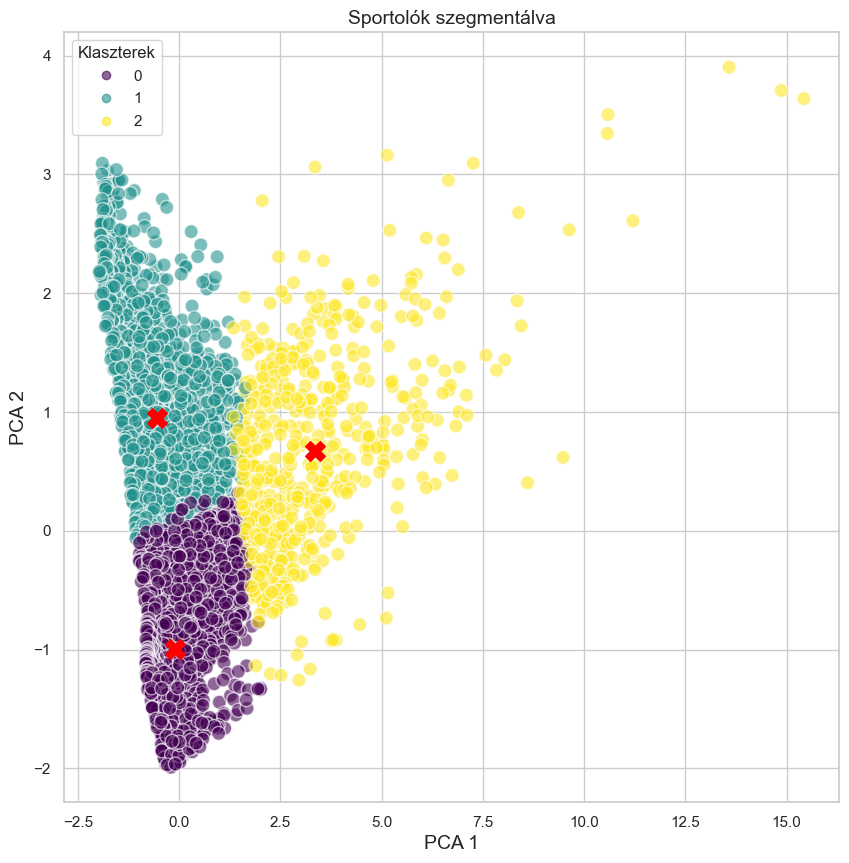

In [ ]:
# PCA vizualizálása
fs = 14  # betűméret

# Adatkeret létrehozása a PCA adatokhoz
create_pca_frame = lambda pcd: pd.DataFrame(pcd, columns=[str(x) for x in range(pcd.shape[1])])
pca_frame = create_pca_frame(dataset_1)

# Predikció hozzáadása
pca_frame['pred'] = pd.Series(y_kmeans)  # Klaszterek

# Klaszterközpontok
centers = kmeans.cluster_centers_
pca_centers = pd.DataFrame(pca.transform(centers), columns=['0', '1'])

plt.figure(figsize=(10, 10))
plt.title('Sportolók szegmentálva', fontsize=fs)
scatter = plt.scatter('0', '1', s=100, c='pred', data=pca_frame, cmap='viridis', alpha=0.6, edgecolors='w')
scatter_centers = plt.scatter('0', '1', s=200, color='red', marker='X', data=pca_centers)
plt.xlabel('PCA 1', fontsize=fs)
plt.ylabel('PCA 2', fontsize=fs)
plt.legend(*scatter.legend_elements(), title='Klaszterek')
plt.grid(True)
plt.show()

### Loading Score (A loading score megadja, mennyiben felel a varianciáért adott változó)

In [ ]:
# Loading Score
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)

# Loading scores kiszámítása a főkomponenshez
loading_scores = pd.Series(pca.components_[0], index=df.columns[:-1])  # A '-1' azért van, mert a df már tartalmaz egy 'Klaszter' oszlopot
sorted_loading_scores = loading_scores.abs().sort_values(ascending=False)

# Loading scores kiíratása
print("Loading scores (sorted):")
print(sorted_loading_scores)

Loading scores (sorted):
versenyek_szama       0.653281
pontszam              0.643464
napok_ota             0.398845
teljesitmeny_index    0.009653
sport_id              0.002748
dtype: float64


### Scree plot (a főkomponensek sorrendben történő megjelenítése, ahol az egyes komponensekhez tartozó variancia százalékát ábrázolja a tengelyeken.)

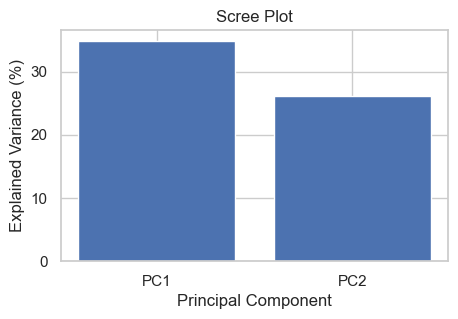

In [ ]:
# Scree plot a főkomponensek varianciájának megjelenítésére
plt.figure(figsize=(5, 3))
per_var = np.round(pca.explained_variance_ratio_ * 100, decimals=1)
labels = ['PC' + str(x) for x in range(1, len(per_var) + 1)]
plt.bar(x=range(1, len(per_var) + 1), height=per_var, tick_label=labels)
plt.ylabel('Explained Variance (%)')
plt.xlabel('Principal Component')
plt.title('Scree Plot')
plt.show()